# Using Cleanlab to Determine Examples to Collect Additional Labels for in an Active Learning Loop to Improve Classification Models 

This example demonstrates how to compute an active learning score for every datapoint in your dataset, and shows how a classification model improves after relabeling examples for multiple rounds. The datapoints in the dataset will have been annotated by multiple annotators, and not all datapoints have to be labeled at the beginning. The computed active learning score will indicate if you should collect more labels for an already-labeled example, or get a label for an example that has not been labeled.

This notebook will demonstrate the following steps:

1. Train a model on the current consensus labels to obtain out-of-sample predicted probabilities for each datapoint
2. Compute active learning scores for every datapoint, this score indicates the quality and confidence of each datapoint's label, where a low active learning score indicates that we should get more
3. Collect additional labels for the datapoints with the lowest active learning scores
4. Repeat the steps above with a new set of consensus labels obtained after collecting more labels

In this example we used a modified version of the [Wall-Following Robot Navigation](https://www.openml.org/search?type=data&sort=runs&status=any&qualities.NumberOfClasses=gte_2&qualities.NumberOfInstances=between_1000_10000&id=1526) dataset, where we synthetically generated multiple annotations for each datapoint with some noise. 

## Import dependencies and get data

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

from cleanlab.multiannotator import get_majority_vote_label, get_label_quality_multiannotator, get_active_learning_scores

from utils.model_training import train_model
from utils.active_learning import get_idx_to_relabel, setup_next_iter_data, add_new_annotator


In [2]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ActiveLearning/WallRobot/data.tar.gz'
!tar -xf data.tar.gz data/

File ‘data.tar.gz’ already there; not retrieving.



In [3]:
multiannotator_labels = pd.DataFrame(np.load("data/multiannotator_labels_labeled.npy"))

X_labeled = np.load("data/X_labeled.npy")
X_unlabeled = np.load("data/X_unlabeled.npy")

extra_labels_labeled = np.load("data/extra_labels_labeled.npy")
extra_labels_unlabeled = np.load("data/extra_labels_unlabeled.npy")

X_test = np.load("data/X_test.npy")
true_labels_test = np.load("data/true_labels_test.npy")


We loaded the following datafiles:

- `multiannotator_labels` is a DataFrame that contains labels from multiple annotators for each datapoint
- `X_labeled` are the features for the datapoints that have been labeled by at least one annotator
- `X_unlabeled` are the features for the datapoints that have not been labeled by any annotator

Additionally, we loaded these extra files for simulation and demontration purposed and would usually not be available:

- `extra_labels_labeled` and `extra_labels_unlabeled` are synthetically created extra labels that will be sampled from when we get more labels later in this notebook
- `X_test` and `true_labels_test` are used to measure the model accuracy 

## Train model to obtain pred_probs

In [4]:
consensus_labels = get_majority_vote_label(multiannotator_labels)

pred_probs, pred_probs_unlabeled, model_accuacy = train_model(
    ExtraTreesClassifier(),
    X_labeled,
    consensus_labels,
    cv_n_folds=5,
    X_unlabeled=X_unlabeled,
    X_test=X_test,
    labels_test=true_labels_test,
)


## Obtain active learning scores

In [5]:
active_learning_score, active_learning_score_unlabeled = get_active_learning_scores(
    multiannotator_labels, pred_probs, pred_probs_unlabeled
)


## Get index to relabel

In [6]:
relabel_idx, relabel_idx_unlabeled = get_idx_to_relabel(
    active_learning_score=active_learning_score,
    active_learning_score_unlabeled=active_learning_score_unlabeled,
    num_examples_to_relabel=100,
)


## Demo

In [7]:
num_rounds = 15
num_examples_to_relabel = 100

In [8]:
model_accuacy_arr = np.full(num_rounds, np.nan)

for i in range(num_rounds):
    if i == 0:
        consensus_labels = get_majority_vote_label(multiannotator_labels)
    else:
        # we can use the pred_probs from last round as the best model estimate
        results = get_label_quality_multiannotator(multiannotator_labels, pred_probs_labeled, temp_scale=True)
        consensus_labels = results["label_quality"]["consensus_label"]

    pred_probs, pred_probs_unlabeled, model_accuacy = train_model(
        ExtraTreesClassifier(),
        X_labeled,
        consensus_labels,
        cv_n_folds=5,
        X_unlabeled=X_unlabeled,
        X_test=X_test,
        labels_test=true_labels_test,
    )
    print(model_accuacy)

    active_learning_score, active_learning_score_unlabeled = get_active_learning_scores(
        multiannotator_labels, pred_probs, pred_probs_unlabeled
    )

    relabel_idx, relabel_idx_unlabeled = get_idx_to_relabel(
        active_learning_score=active_learning_score,
        active_learning_score_unlabeled=active_learning_score_unlabeled,
        num_examples_to_relabel=num_examples_to_relabel,
    )

    (
        multiannotator_labels, relabel_idx_combined, X_labeled, X_unlabeled, pred_probs_labeled, 
        pred_probs_unlabeled, extra_labels_labeled, extra_labels_unlabeled,
    ) = setup_next_iter_data(
        multiannotator_labels, relabel_idx, relabel_idx_unlabeled, X_labeled, X_unlabeled, pred_probs, 
        pred_probs_unlabeled, extra_labels_labeled, extra_labels_unlabeled,
    )

    multiannotator_labels = add_new_annotator(
        multiannotator_labels, extra_labels_labeled, relabel_idx_combined
    )

    model_accuacy_arr[i] = model_accuacy

0.8973333333333333
0.9243333333333335
0.9313333333333332
0.9433333333333334
0.9560000000000001
0.9593333333333334
0.961
0.9696666666666667
0.9790000000000001
0.9736666666666667
0.9723333333333333
0.975
0.9719999999999999
0.9806666666666667
0.9746666666666666


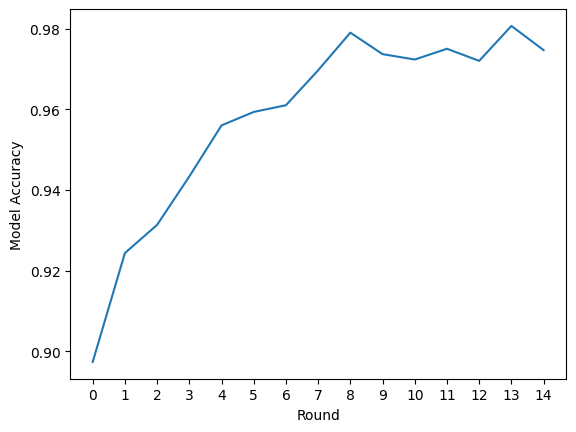

In [9]:
plt.plot(model_accuacy_arr)
plt.xticks(range(num_rounds))
plt.xlabel("Round")
plt.ylabel("Model Accuracy")
plt.show()